Para realizar el análisis de segmentación con algoritmos de machine learning se ha considerado un conjunto de datos de tárjeta de crédito de un banco, donde se cuenta con algunas características del cliente como edad, género, trabajo, duración, propósito del crédito, entre otros.

**Analisis de Negocio**

---

**Variables**
1. Edad (numérico)
2. Sexo (texto: masculino, femenino)
3. Trabajo (numérico: 0 - no calificado y no residente, 1 - no calificado y residente, 2 - calificado, 3 - altamente calificado)
4. Vivienda (texto: propio, alquiler o gratis)
5. Cuentas de ahorro (texto: poco, moderado, bastante rico, rico)
6. Cuenta corriente (numérica, en DM - Marca alemana)
7. Monto de crédito (numérico, en DM)
8. Duración (numérica, en mes)
9. Propósito (texto: automóvil, muebles / equipo, radio / TV, electrodomésticos, reparaciones, educación, negocios, vacaciones / otros)


### Conexion Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### Librerias

In [2]:
!pip install plotly

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import plotly

pd.options.display.max_columns = None #Para que se visualicen todas las variables
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Para los graficos tengan las mismas dimensiones
%matplotlib inline
plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (7, 4)

pd.options.display.max_columns = None
sns.set_style('whitegrid')
color = sns.color_palette()

## Rutas

In [5]:
#Repositorios
path = '/gdrive/MyDrive/BQ - Data Science/BQ - Repositorios/Repositorio_Portafolio/'
filename = "Data_banca_segmentacion.csv"
fullpath = os.path.join(path, filename)

# Lectura de datos

In [6]:
df = pd.read_csv(fullpath,encoding='latin1')

In [7]:
print(df.shape)
df.head(3)

(1000, 11)


,Unnamed: 0.1,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,2,49,male,1,own,little,NaN,2096,12,education


# Data Wrangling

In [8]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing',
       'Saving accounts', 'Checking account', 'Credit amount', 'Duration',
       'Purpose'],
      dtype='object')

In [9]:
# Validamos si los tipos de variables son los adecuados

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0.1      1000 non-null   int64 
 1   Unnamed: 0        1000 non-null   int64 
 2   Age               1000 non-null   int64 
 3   Sex               1000 non-null   object
 4   Job               1000 non-null   int64 
 5   Housing           1000 non-null   object
 6   Saving accounts   817 non-null    object
 7   Checking account  606 non-null    object
 8   Credit amount     1000 non-null   int64 
 9   Duration          1000 non-null   int64 
 10  Purpose           1000 non-null   object
dtypes: int64(6), object(5)
memory usage: 86.1+ KB


Parece que la primera columna es simplemente un índice que podemos eliminar. Comprobamos cuántos valores faltantes hay en cada columna y de qué tipos de datos son.

In [11]:
df.drop(df.columns[0:2], inplace=True, axis=1)
print("Base de datos tiene {} observaciones (clientes) y {} columnas (variables).".format(df.shape[0],df.shape[1]))
print("Valores perdidos por cada variable:\n{}".format(df.isnull().sum()))
print("Tipo de variables:\n{}".format(df.dtypes))

Base de datos tiene 1000 observaciones (clientes) y 9 columnas (variables).
Valores perdidos por cada variable:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
Tipo de variables:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


De las 9 columnas 2 contienen valores faltantes. Probablemente se trata de clientes que no tienen una de estas dos cuentas.

En general, hay 4 variables numéricas y 5 categóricas.

Ahora comprobamos cuántos y cuáles son los valores posibles (únicos) en cada columna categórica.

In [12]:
n_unique = df.nunique()
print("Número de valores únicos:\n{}".format(n_unique))

Número de valores únicos:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [13]:
print("Valores únicos en cada columna categórica:")
for col in df.select_dtypes(include=[object]):
    print(col,":", df[col].unique())

Valores únicos en cada columna categórica:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


In [15]:
columnsString = [x for x in df.select_dtypes(include=[object])]
columnsNumeric = [x for x in df.columns if x not in columnsString]

# **I. Analisis Exploratorio**

In [16]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1000.0,NaN,NaN,NaN,35.546,11.375469,19.0,27.0,33.0,42.0,75.0
Sex,1000,2,male,690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job,1000.0,NaN,NaN,NaN,1.904,0.653614,0.0,2.0,2.0,2.0,3.0
Housing,1000,3,own,713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saving accounts,817,4,little,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checking account,606,3,little,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit amount,1000.0,NaN,NaN,NaN,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,NaN,NaN,NaN,20.903,12.058814,4.0,12.0,18.0,24.0,72.0
Purpose,1000,8,car,337,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analisis Univariado

### Categoricas

Sex
female    310
male      690
dtype: int64


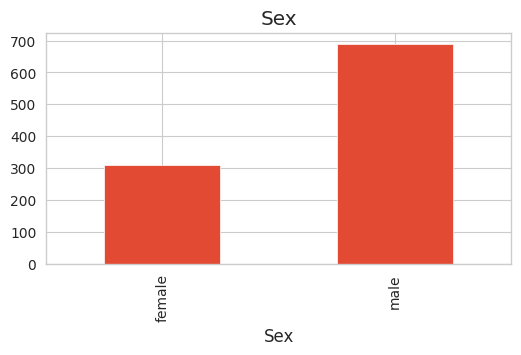

Housing
free    108
own     713
rent    179
dtype: int64


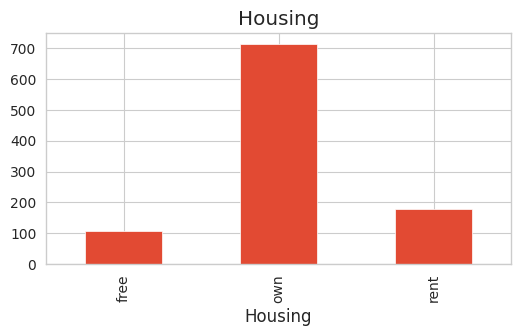

Saving accounts
little        603
moderate      103
quite rich     63
rich           48
dtype: int64


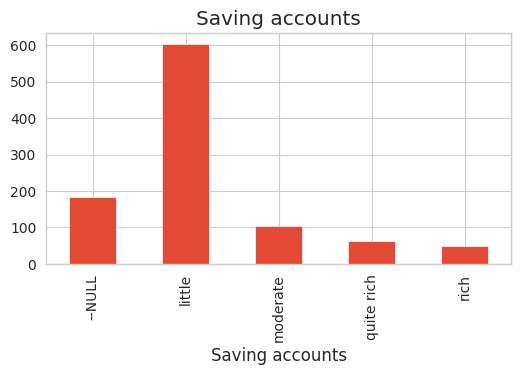

Checking account
little      274
moderate    269
rich         63
dtype: int64


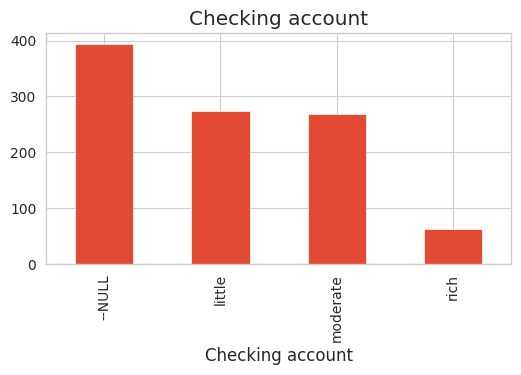

Purpose
business                97
car                    337
domestic appliances     12
education               59
furniture/equipment    181
radio/TV               280
repairs                 22
vacation/others         12
dtype: int64


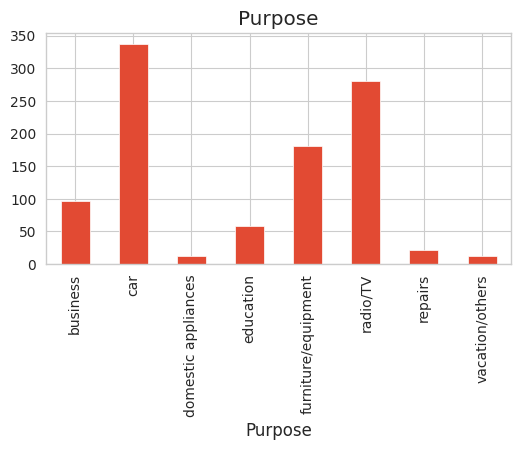

In [17]:
for x in columnsString:
  plt.figure(figsize=(6,3))
  print(df.groupby(x).size())
  plt.title(x)
  df.fillna("--NULL").groupby(x)[x].count().plot(kind = "bar")
  plt.show()

### Numericas

In [18]:
df[columnsNumeric].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.0,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0


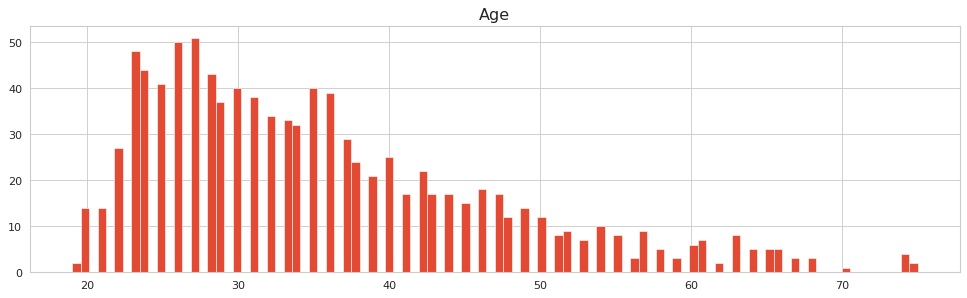

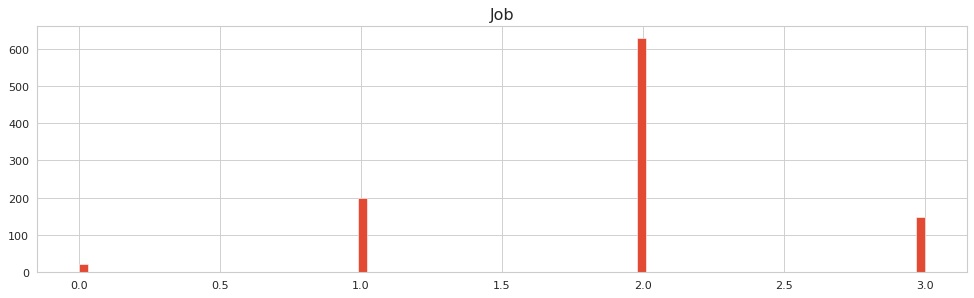

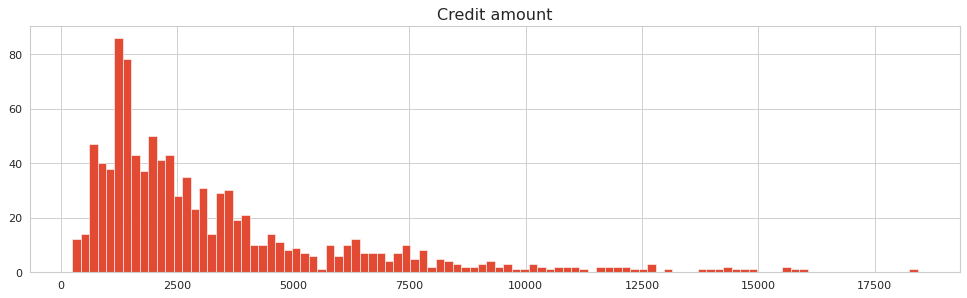

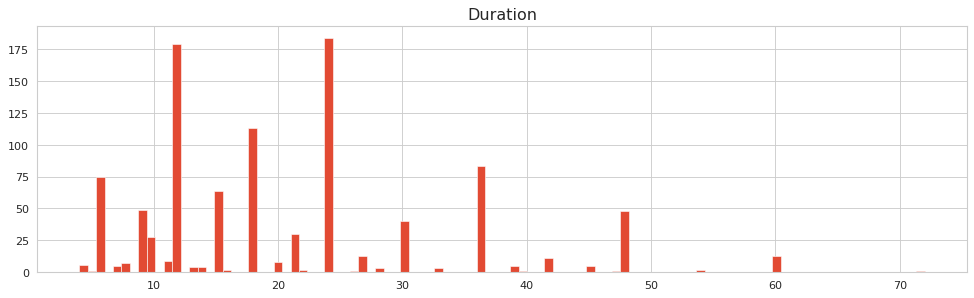

In [19]:
for x in columnsNumeric:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df[x].name)
  plt.hist(df[x],bins=100)
  plt.show()

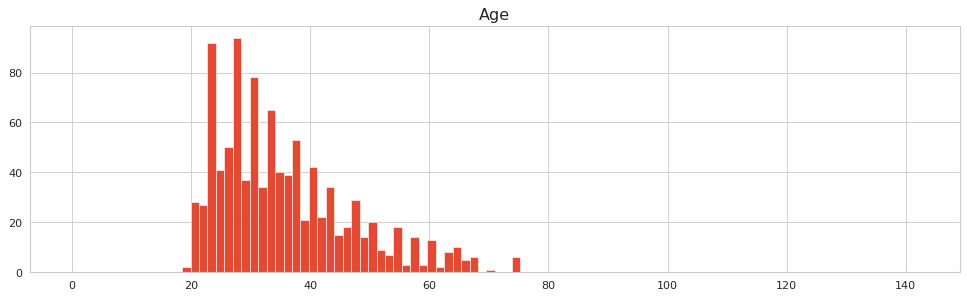

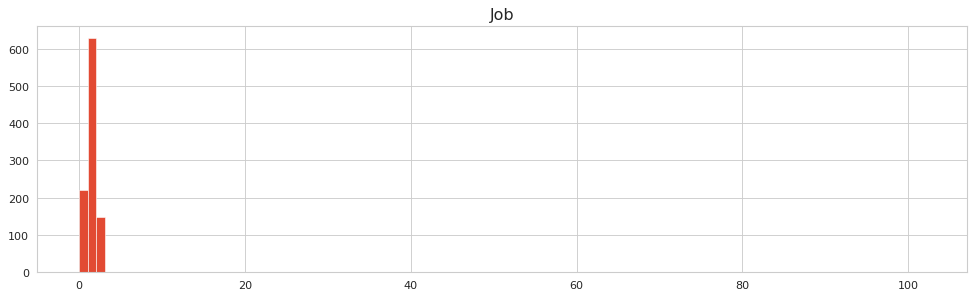

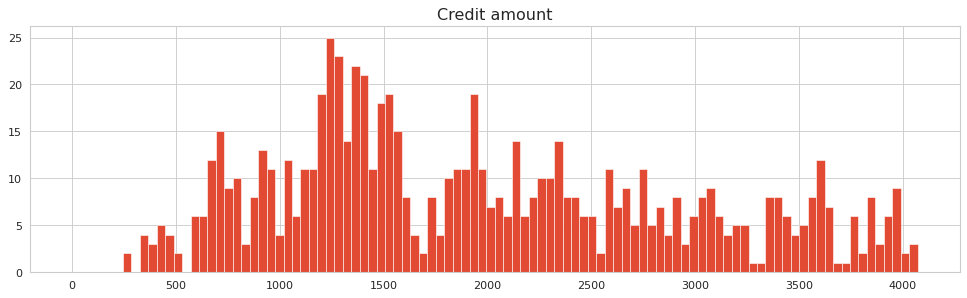

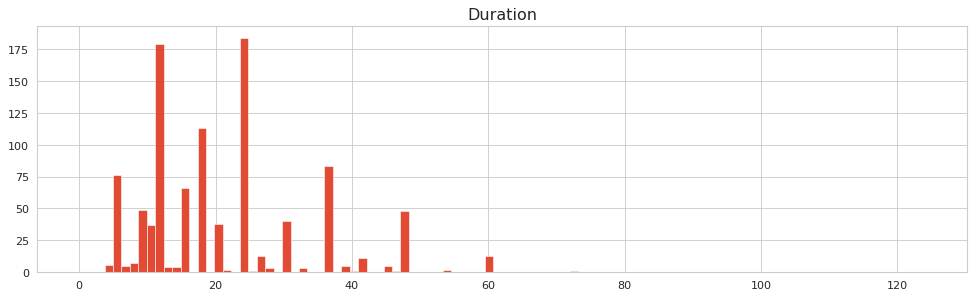

In [20]:
# No consideramos las colas (outliers) para ver mejor la distribucion
for x in columnsNumeric:
  plt.figure(figsize=(15,4), dpi=80)
  Q03= int(df[x].quantile(0.75))+100
  plt.title(df[x].name)
  plt.hist(df[x],bins=100,range=(0,Q03))
  plt.show()

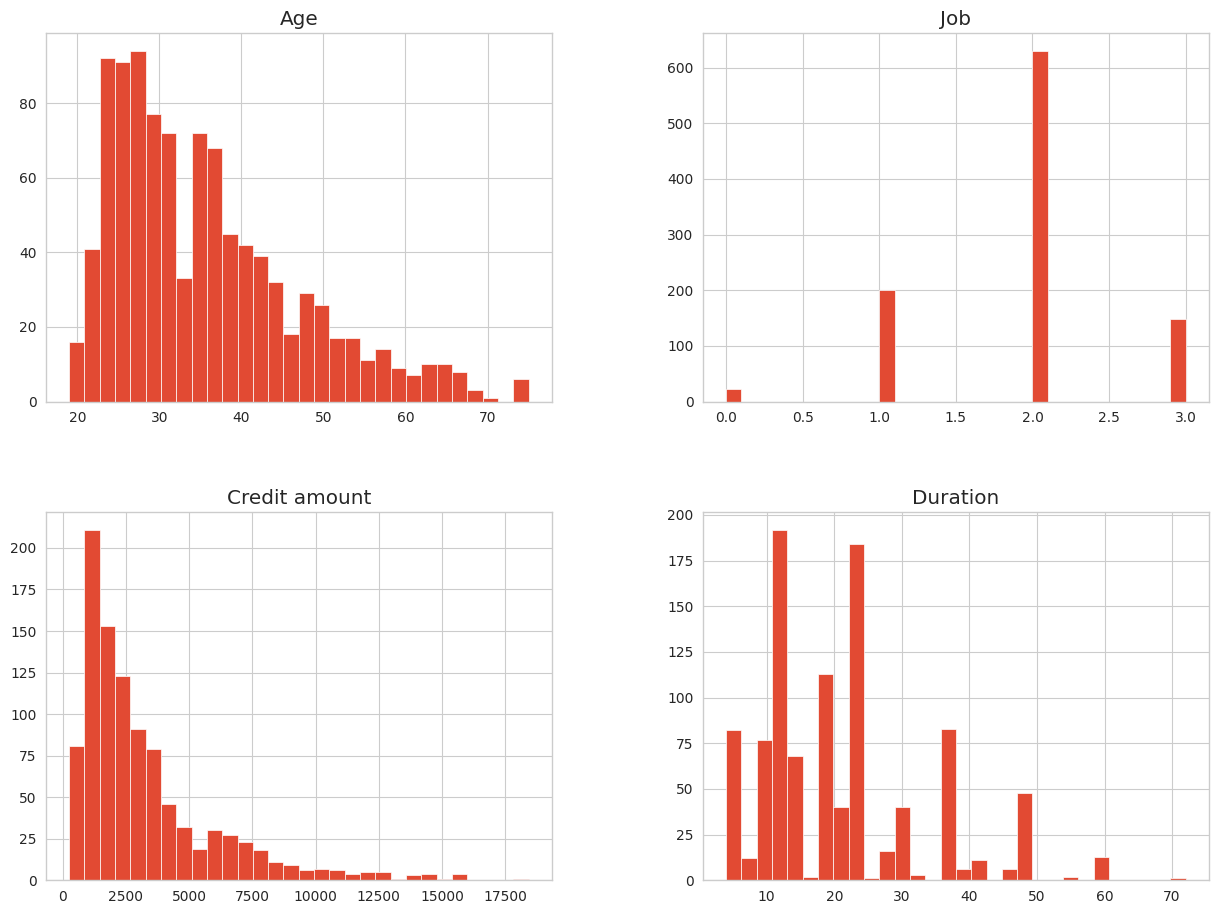

In [21]:
df[columnsNumeric].hist(bins = 30, figsize=(15,11))
plt.show()

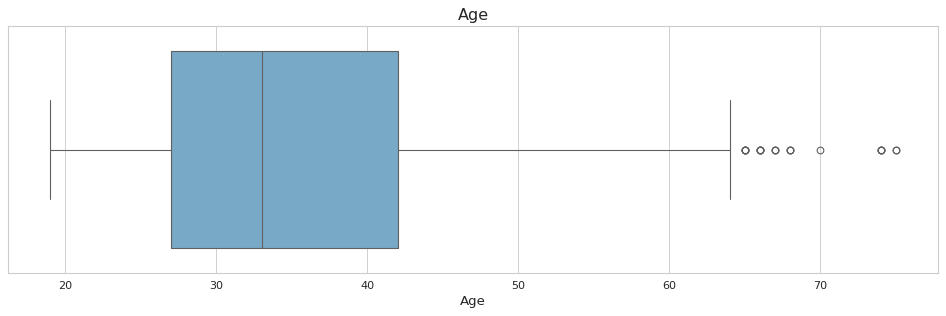

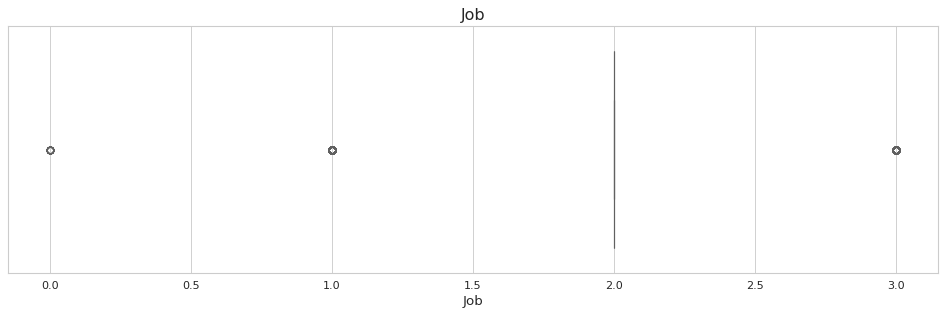

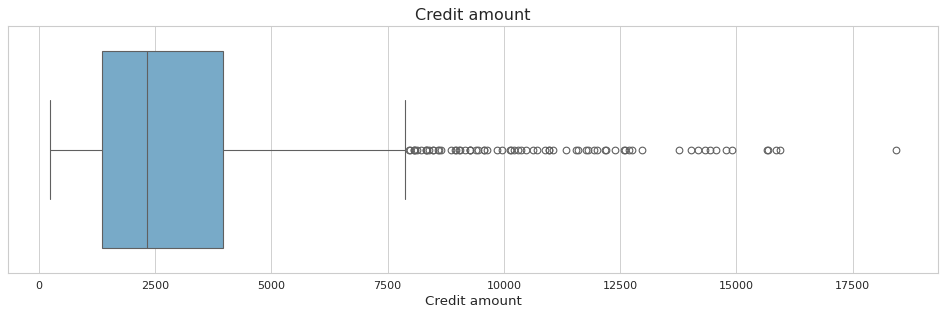

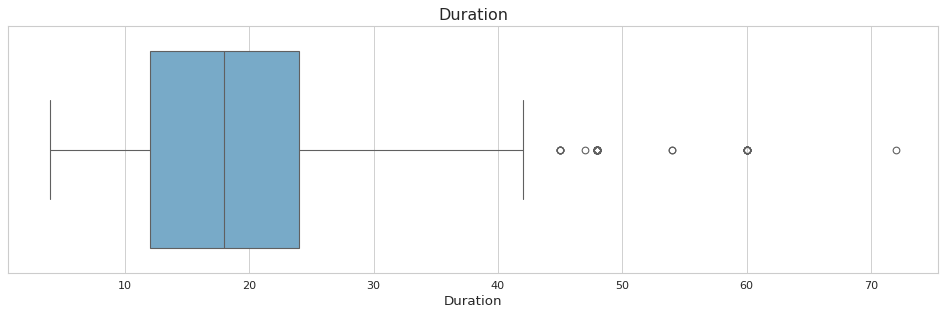

In [22]:
# Grafico de Cajas para revision de atipicos
for x in columnsNumeric:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df[x].name)
  sns.boxplot(x=df[x], palette="Blues")
  plt.show()

## Anlisis Bivariado

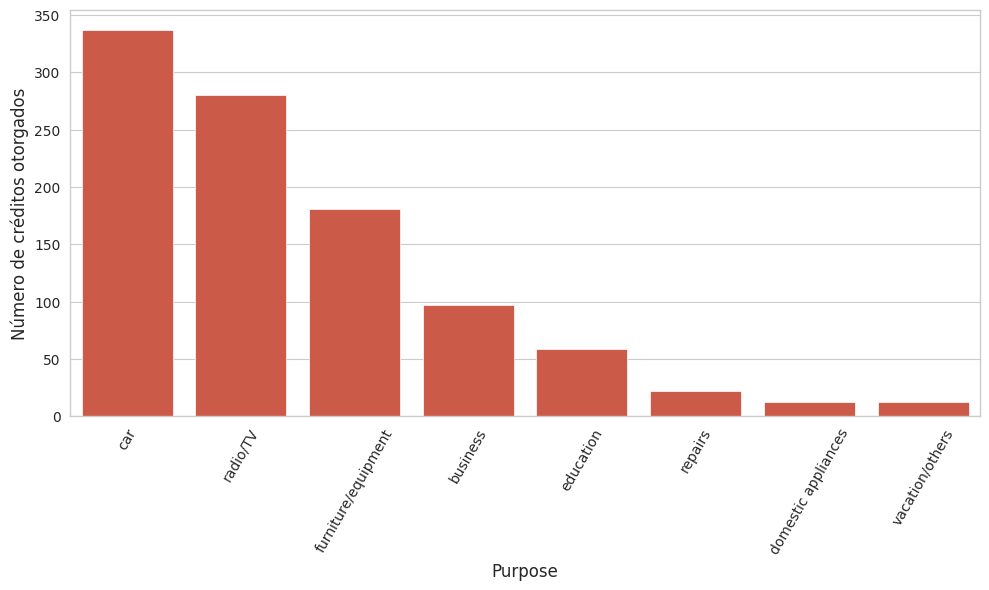

In [31]:
n_credits = df.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Número de créditos otorgados")
plt.tight_layout()

El diagrama de barras anterior muestra cuántos créditos se otorgaron para diversos fines. La mayoría de los créditos se otorgaron para automóviles y radio / TV.

Ahora generaremos diagramas de caja para el análisis detallado de variables categóricas.

In [32]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=df)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

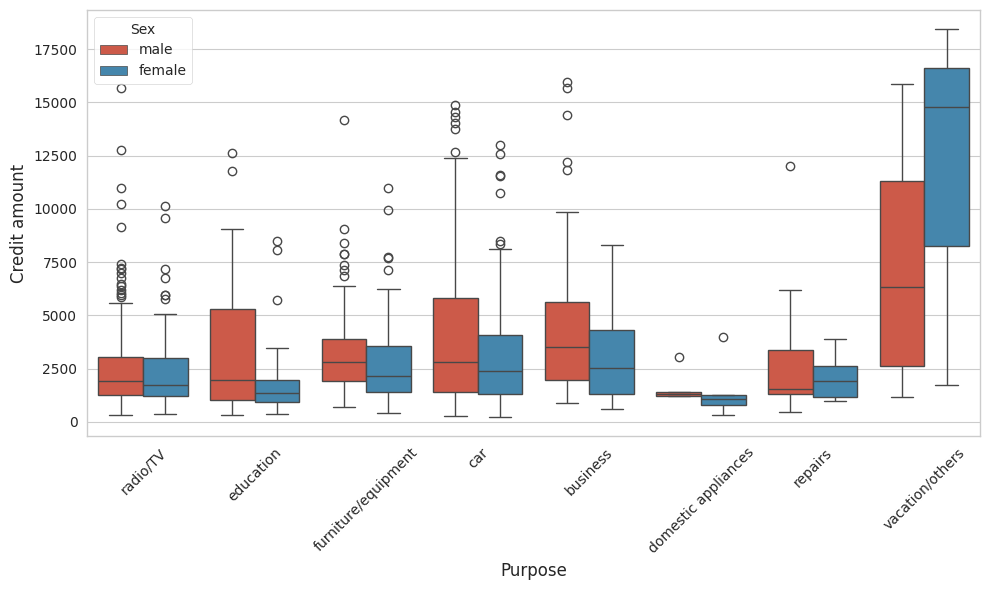

In [33]:
boxes("Purpose","Credit amount","Sex")

La gráfica anterior muestra que las cantidades más grandes se toman para vacaciones / otros, las más pequeñas para electrodomésticos.

La mayoría de ellos tienen valores atípicos en la parte superior de las cajas (cantidades más altas).

En la mayoría de los casos no hay diferencia entre hombres y mujeres, a pesar de la categoría vacaciones / otros. Pero uno debe recordar que había muy pocos créditos otorgados en esta categoría.

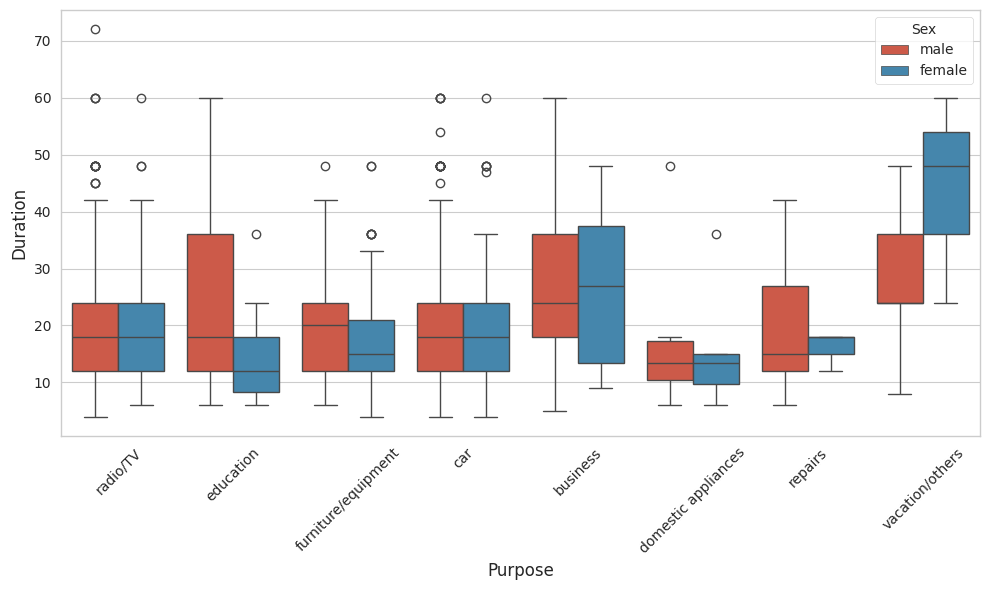

In [34]:
boxes("Purpose","Duration","Sex")

El diagrama de caja anterior indica que generalmente no hay diferencia en la duración del crédito entre hombres y mujeres. No podemos ver también una tendencia clara entre las categorías con observaciones de que la duración más corta es para electrodomésticos.

Tiene sentido ya que está de acuerdo con las ideas del gráfico anterior (monto del crédito): en esta categoría, hay los montos más bajos de créditos.

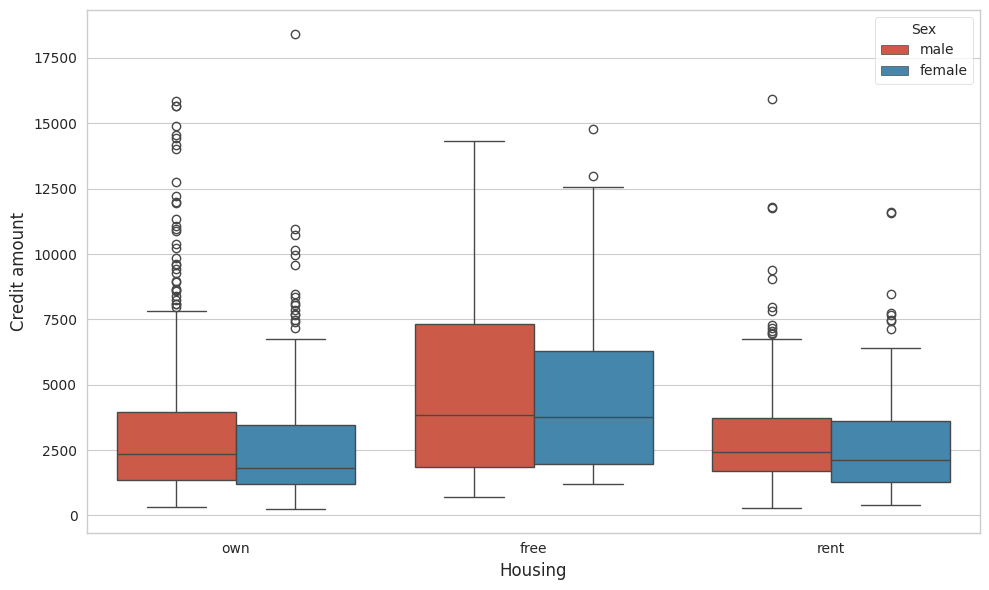

In [35]:
boxes("Housing","Credit amount","Sex",r=0)

En términos de categoría de vivienda, no existe una gran diferencia a pesar de que las personas que tienen viviendas "gratuitas" tienden a tomar montos de crédito ligeramente mayores.

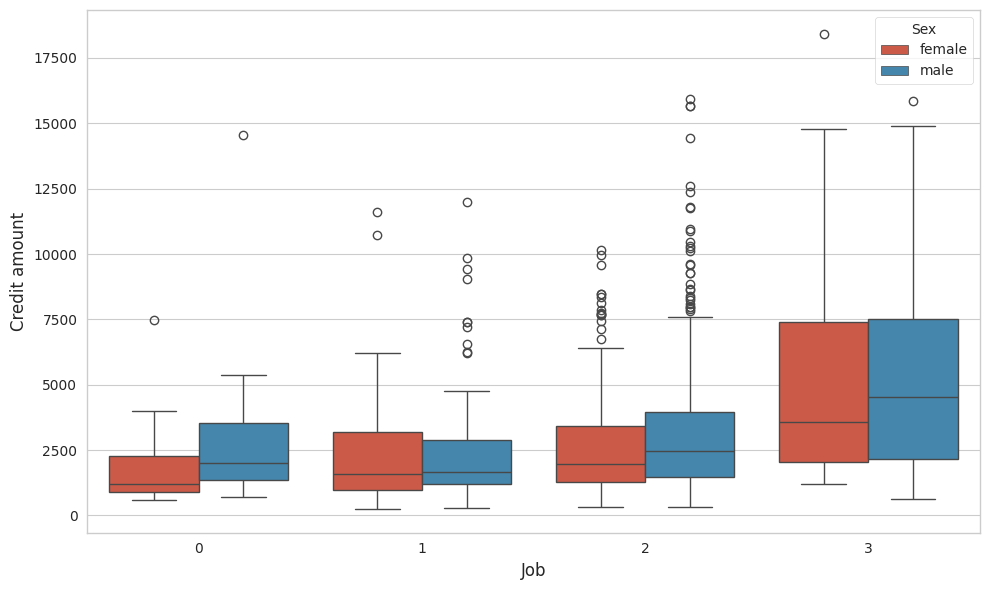

In [36]:
boxes("Job","Credit amount","Sex",r=0)

En términos de categoría de trabajo, una vez más no hay diferencia entre hombres y mujeres, pero podemos ver que la categoría de trabajo 3 ("Altamente calificado") tiende a tomar montos de crédito más grandes para una mayor duración.

Y al final, si a alguien le gustan las tramas 3D, aquí tienes.

Text(0.5, 0, 'Age')

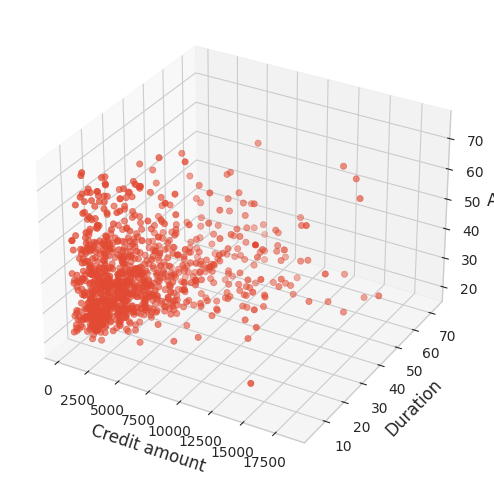

In [37]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df["Credit amount"], df["Duration"], df["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

## Analisis Multivariado

### **Correlacion**
Podemos realizar un analisis de correlación entre variablles

<Axes: >

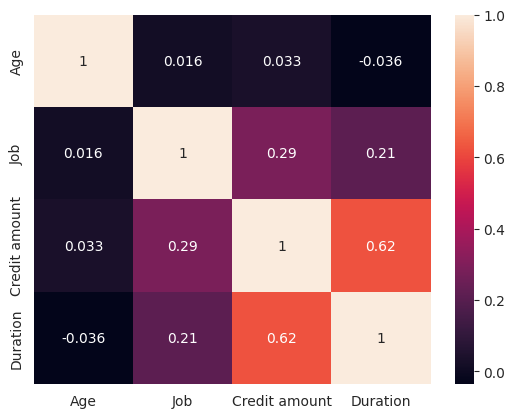

In [23]:
sns.heatmap(df.corr(),annot=df.corr())

Definimos una función que generará gráficos para tres variables numéricas con estratificación por columna categórica seleccionada.

In [24]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

Al principio, veamos los diagramas de dispersión de nuestras 3 variables numéricas estratificadas por sexo

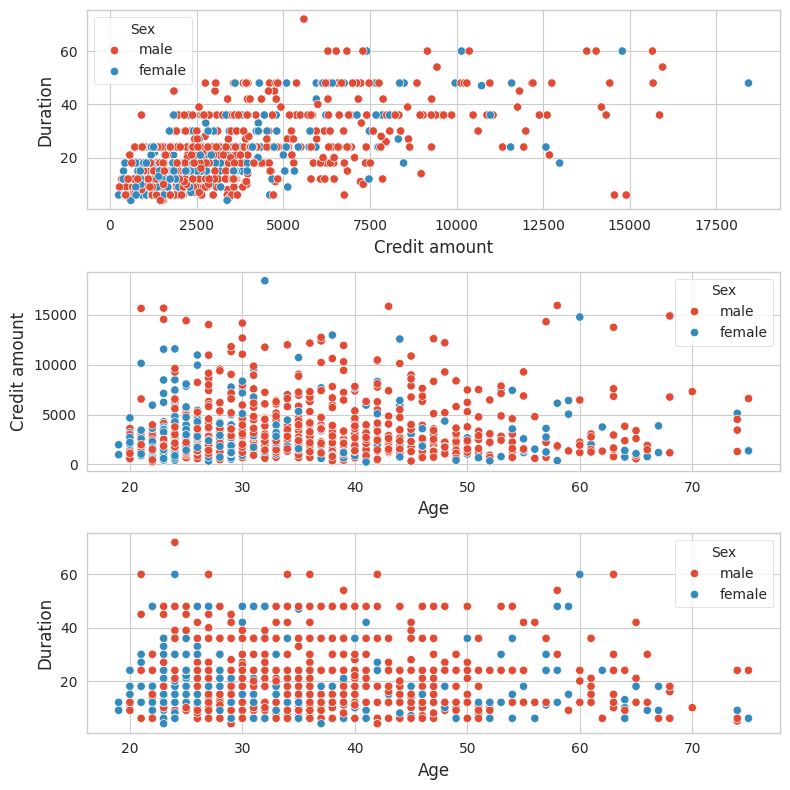

In [26]:
scatters(df, h="Sex")

* La impresión general es que las mujeres tienden a ser más jóvenes que los hombres, sin embargo, la primera gráfica muestra que no hay una diferencia clara entre hombres y mujeres en términos de monto y duración del crédito.

* De la inspección visual, parece que hay una correlación positiva entre la duración y la cantidad de crédito, lo que tiene sentido.

* Verifiquemos la correlación lineal entre el monto del crédito y la duración.




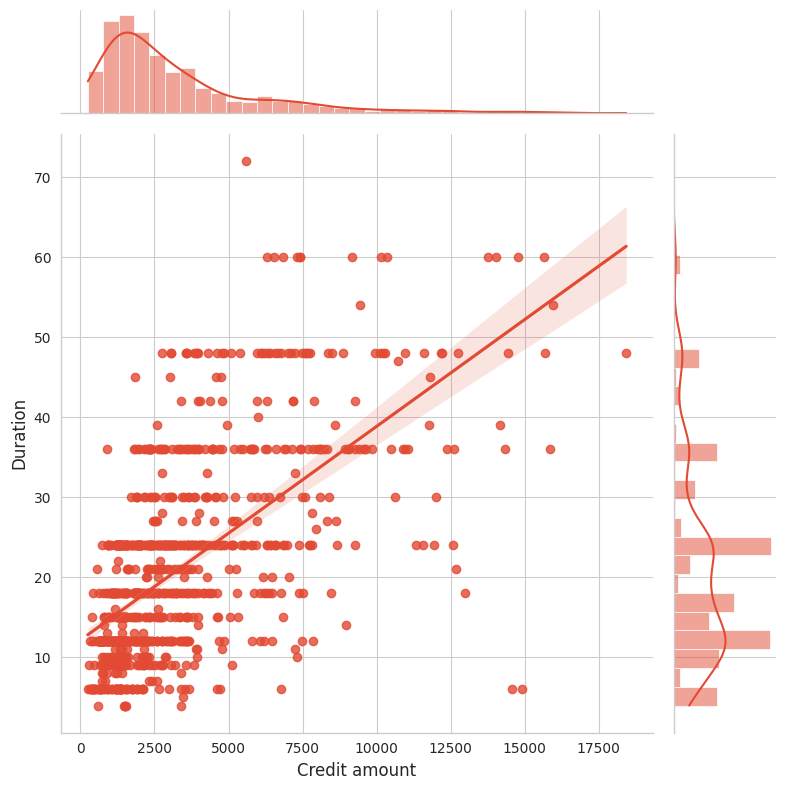

In [27]:
import scipy.stats as stats
r1 = sns.jointplot(x="Credit amount",y="Duration", data=df, kind="reg", height=8)
r1.ax_joint.text
#r1.annotate(stats.pearsonr)
plt.show()

El gráfico anterior muestra una correlación lineal con el valor de Pearson de 0.62 y un valor p muy pequeño.

Eso tiene sentido porque, por lo general, las personas toman créditos más grandes por períodos más largos. A continuación analizaré gráficos de regresión lineal con varias categorizaciones.

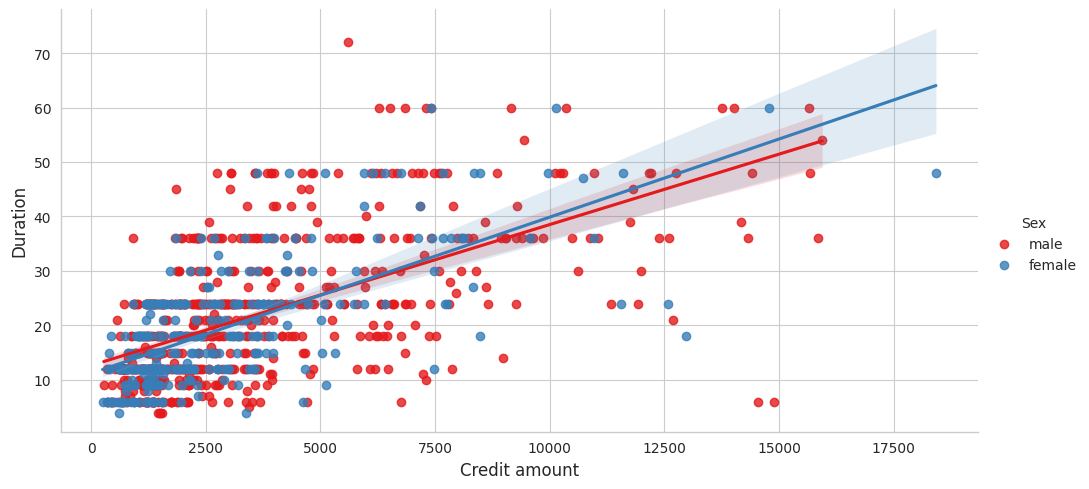

In [28]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=df, palette="Set1", aspect=2)
plt.show()

La gráfica anterior indica que no hay una diferencia significativa entre hombres y mujeres.

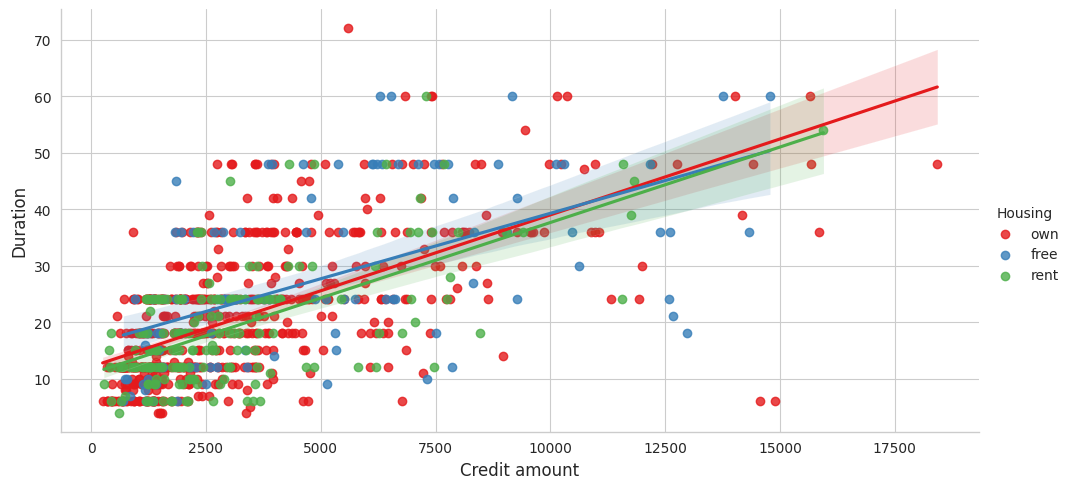

In [29]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=df, palette="Set1", aspect=2)
plt.show()

La gráfica anterior muestra de manera similar que no hay diferencia entre las categorías de viviendas.

A continuación, mostraré el área de "negocios" donde se otorga la mayor cantidad de créditos.

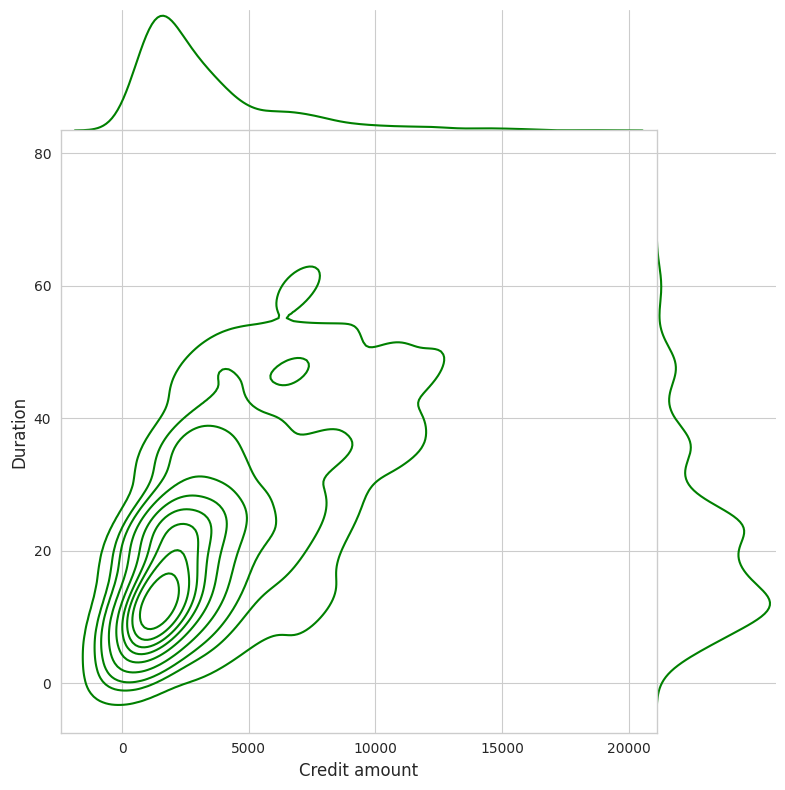

In [30]:
sns.jointplot(x="Credit amount",y="Duration", data=df, kind="kde", space=0, color="g",  height=8)
plt.show()

# **II. Modelado**

In [38]:
data = df.copy()

## **Clustering con KMeans**

Para la agrupación, crearemos un subconjunto que contenga solo variables numéricas (Edad, Cantidad de crédito, Duración).

In [39]:
#Seleccionamos columnas para clusterización con K-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

Creamos una función que genere tres histogramas, uno para cada variable.



In [40]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

Vemos los histogramas



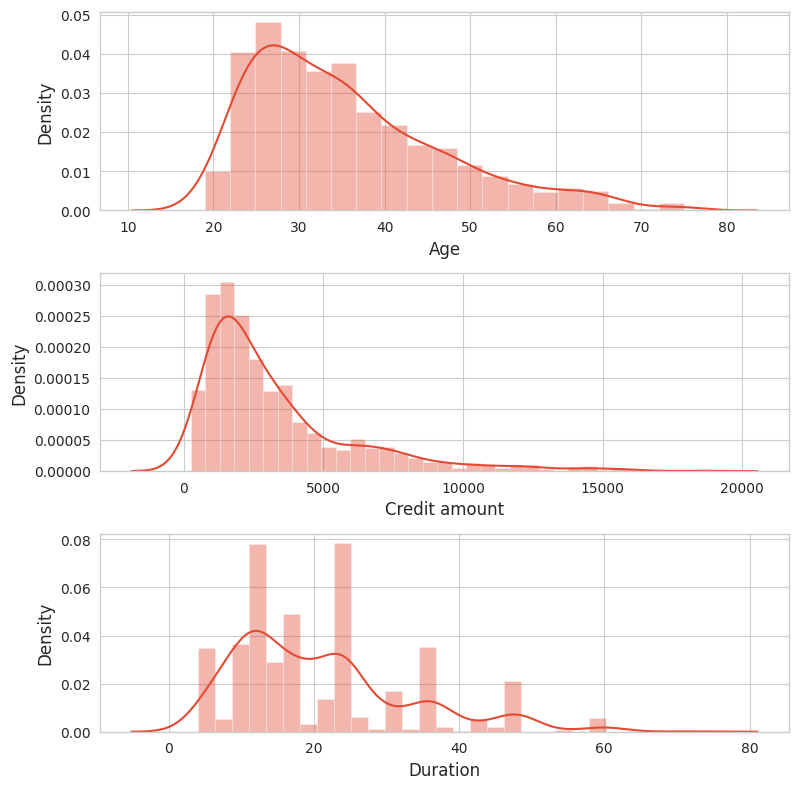

In [41]:
distributions(cluster_data)

Podemos ver que las distribuciones están sesgadas a la derecha, pero para trabajar con clustering necesito que **todas mis variables sean comparables** qué hago:

## **Transformación de variables**

Para obtener mejores resultados, debemos eliminar la asimetría por transformación logarítmica.

Cuando se tienen distribuciones de frecuencias con asimetría negativa (frecuencias altas hacia el lado derecho de la distribución), es conveniente aplicar la transformación logarítmica. Esta transformación comprime la escala para valores pequeños y la expande para valores altos. Muchas distribuciones de datos económicos, o de consumos se convierten en simétricas utilizando esta transformación.

Después de eso, veamos cómo se ven.

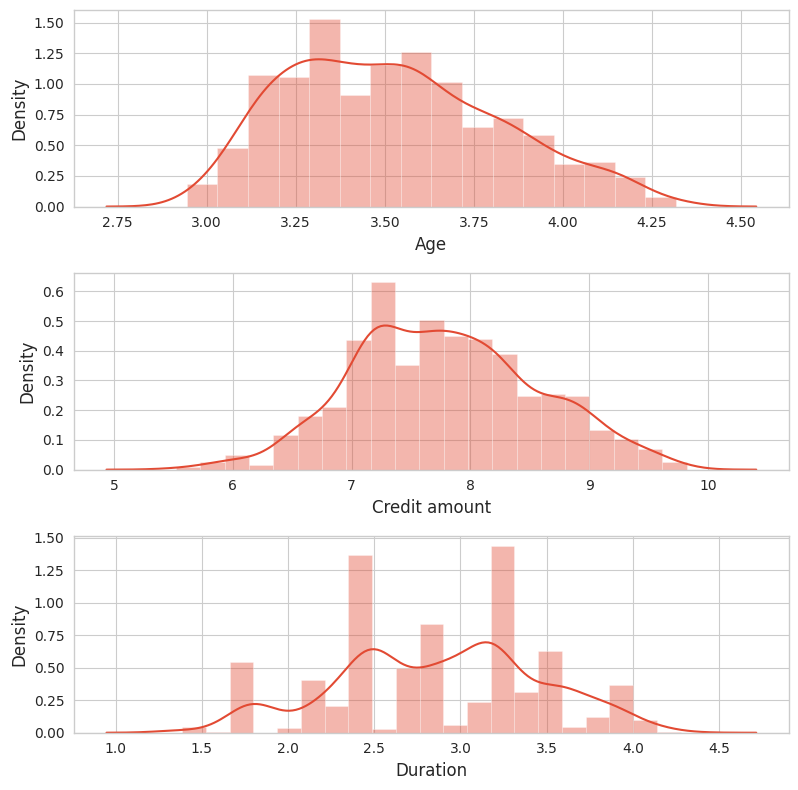

In [42]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

De hecho, la asimetría ha sido eliminada.

## **Estandarización de variables**

El siguiente paso será centrar y escalar las variables: es requerido por el algoritmo KMeans. Utilizaremos para eso un **StandardScaler** de la biblioteca sklearn, la cual estandariza los datos eliminando la media y escalando los datos de forma que su varianza sea igual a 1.

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

**Gráfico de sedimentación**

Nos da una intuición visual de la cantidad de clusters que puedo seleccionar de mi conjunto de datos

Comprobaremos cómo cambia la inercia para varios grupos.

In [45]:
from sklearn.cluster import KMeans

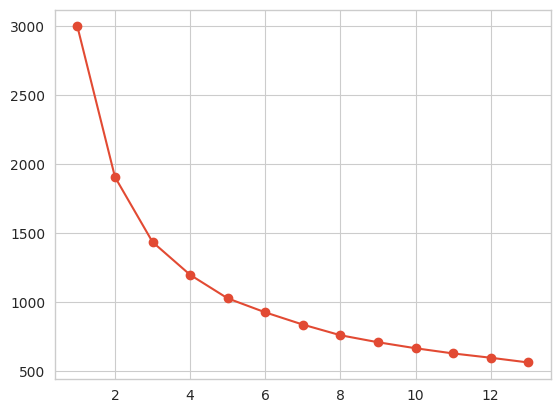

In [46]:
clusters_range = [1,2,3,4,5,6,7,8,9,10,11,12,13]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

El gráfico anterior muestra que la inercia disminuye con el aumento del número de grupos.

Este método además permite la evaluación de las separaciones de grupos y el ajuste de cada observación en su propio grupo.

## **Evaluación de Métricas**

In [47]:
from sklearn import metrics

In [48]:
# Obtenemos los indicadores de clustering:
for i in range(2,15):
    kmeans = KMeans(n_clusters= i)
    kmeans.fit(cluster_scaled)
    cluster = kmeans.predict(cluster_scaled)
    print('cluster con',i,'segmentos')
    print('Inercia: '+str(kmeans.inertia_))
    #print('Silueta: '+str(metrics.silhouette_score(cluster_scaled, cluster, metric='euclidean')))
    print('Silueta: '+str(metrics.silhouette_score(cluster_scaled, cluster, metric='cosine')))
    print('\n')

cluster con 2 segmentos
Inercia: 1908.8110804673893
Silueta: 0.5309765867171055


cluster con 3 segmentos
Inercia: 1437.6902293663688
Silueta: 0.5121609369092928


cluster con 4 segmentos
Inercia: 1199.7055930948868
Silueta: 0.36556693024661435


cluster con 5 segmentos
Inercia: 1029.0410885766237
Silueta: 0.3141374160042335


cluster con 6 segmentos
Inercia: 928.2045948011439
Silueta: 0.2921644918472705


cluster con 7 segmentos
Inercia: 838.739427322264
Silueta: 0.23922938851589112


cluster con 8 segmentos
Inercia: 761.7072703064558
Silueta: 0.2564166466767383


cluster con 9 segmentos
Inercia: 712.7380620569145
Silueta: 0.23086017952881224


cluster con 10 segmentos
Inercia: 667.6235192545939
Silueta: 0.24720021409057874


cluster con 11 segmentos
Inercia: 626.4825979935522
Silueta: 0.22884022080371438


cluster con 12 segmentos
Inercia: 591.2006490117021
Silueta: 0.20802941409679343


cluster con 13 segmentos
Inercia: 565.9392763264277
Silueta: 0.22250576296736316


cluster con 14

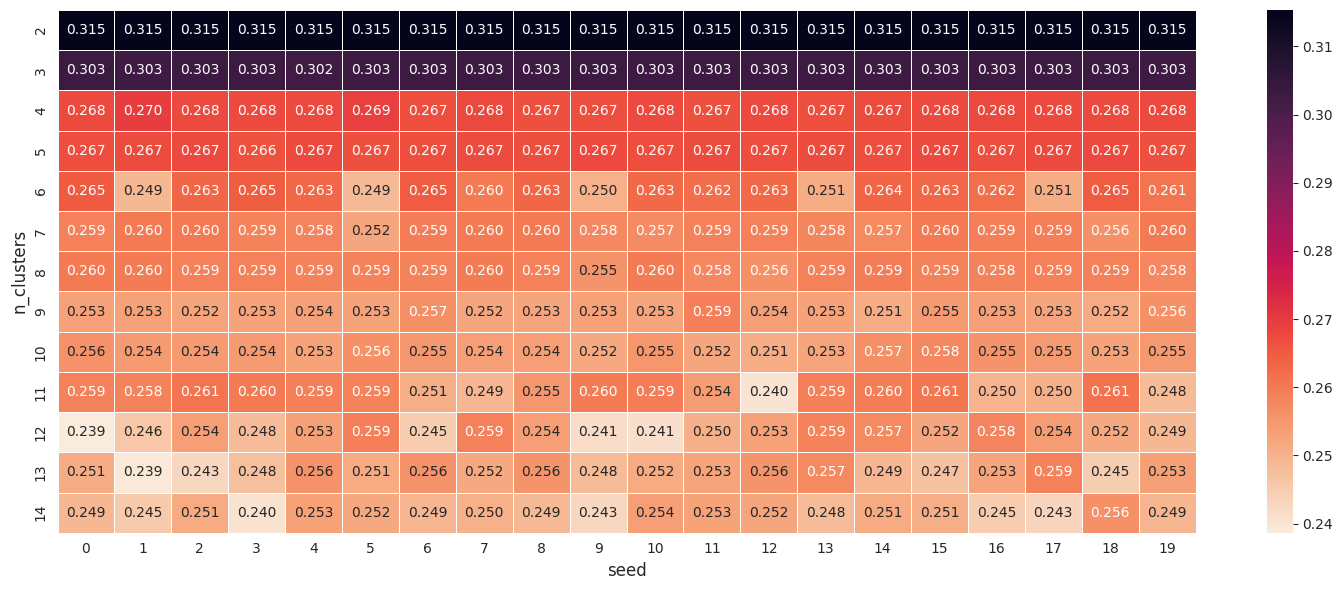

In [49]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

El mapa de calor anterior muestra las puntuaciones de silueta para varias combinaciones de estado aleatorio y número de grupos. Los puntajes más altos son para 2 y 3 grupos y son relativamente insensibles a la semilla.

Elegiré 3 grupos para obtener más información sobre los datos.

In [50]:
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

In [51]:
clustered_data.head()

,Age,Credit amount,Duration,Cluster
0,67,1169,6,0
1,22,5951,48,1
2,49,2096,12,0
3,45,7882,42,1
4,53,4870,24,1


**Interpretación de los clusters**

Definimos una función que muestre los clusters en el diagrama de dispersión.

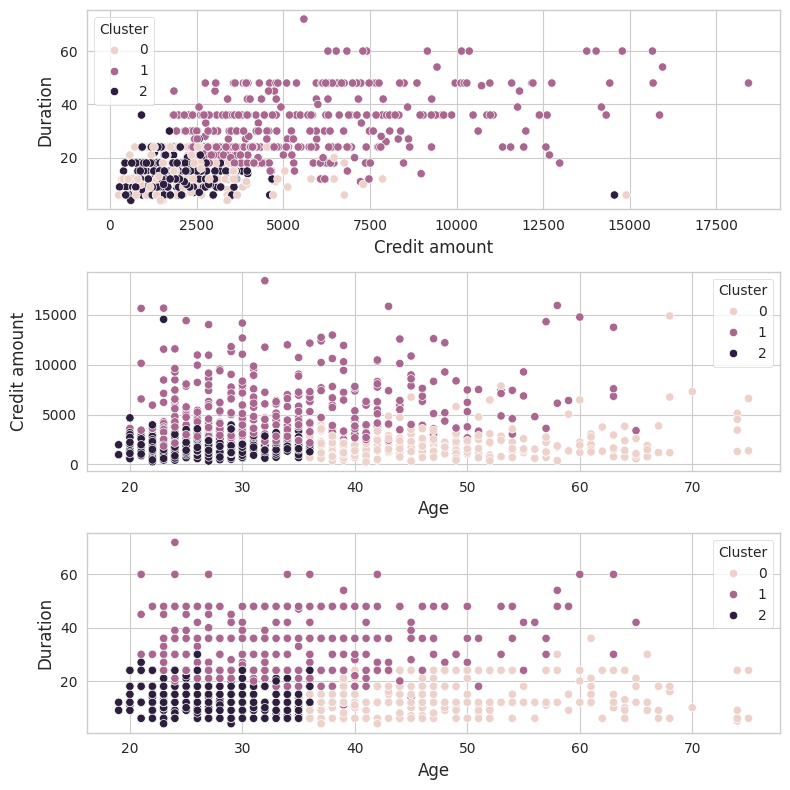

In [52]:
scatters(clustered_data, 'Cluster')

Las gráficas anteriores muestran tres grupos creados. Las dos últimas muestran una separación relativamente clara de los grupos, pero no es tan evidente en el primero.


Calculamos los valores promedios obtenidos en cada variable por cluster.

In [53]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,48.5,1970.3,13.9
1,34.0,5665.4,32.2
2,27.7,1736.3,14.3


1. **Cluster 0** - menor media del monto del crédito, corta duración, clientes mayores

2. **Cluster 1** - alta media del monto del crédito, larga duración, clientes de mediana edad

3. **Cluster 2** - menor media del monto del crédito, corta duración, clientes jóvenes